# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("DifferentialEquations")

  Activating project at `c:\Users\26410\Desktop\Environment A\hw3-bk`
    Updating registry at `C:\Users\26410\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\26410\Desktop\Environment A\hw3-bk\Project.toml`
  No Changes to `C:\Users\26410\Desktop\Environment A\hw3-bk\Manifest.toml`


In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames
using DifferentialEquations

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

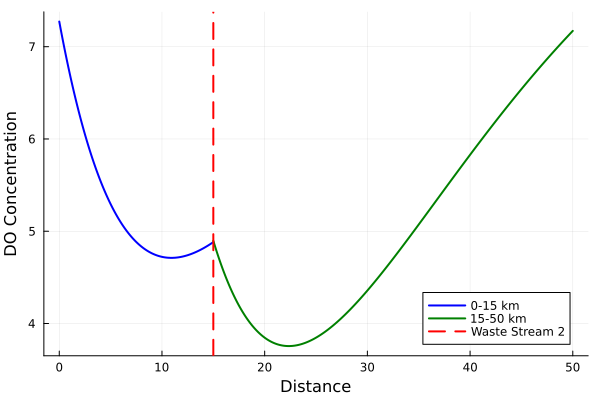

In [4]:
U = 6.0  # km/d
k_a = 0.55  # reaeration rate
C_s = 10.0  # concentration

Q_river = 100000.0  # river inflow
Q_waste1 = 10000.0  # 1 inflow
Q_waste2 = 15000.0  # 2 inflow

DO_river = 7.5  
DO_waste1 = 5.0  
DO_waste2 = 5.0  

k_c = 0.35  # CBOD decay rate 
k_n = 0.25  # NBOD decay rate 

B_01 = 50.0  # CBOD Waste Stream 1 
N_01 = 35.0  # NBOD Waste Stream 1 

B_02 = 45.0  # CBOD lWaste Stream 2 
N_02 = 35.0  # NBOD load Waste Stream 2 

# calculate mixed concentration
function mixed_concentration(Q_river, Q_waste, river, waste)
    return (Q_river * river + Q_waste * waste) / (Q_river + Q_waste)
end

# alpha
function alpha1(x, k_a, U)
    return exp(-k_a * x / U)
end

function alpha2(x, k_a, k_c, U)
    return (k_c / (k_a - k_c)) * (exp(-k_c * x / U) - exp(-k_a * x / U))
end

function alpha3(x, k_a, k_n, U)
    return (k_n / (k_a - k_n)) * (exp(-k_n * x / U) - exp(-k_a * x / U))
end

# Define the C(x)
function C_waste(x, C_0, C_s, B_0, N_0, k_a, k_c, k_n, U)
    a1 = alpha1(x, k_a, U)
    a2 = alpha2(x, k_a, k_c, U)
    a3 = alpha3(x, k_a, k_n, U)
    return C_s * (1 - a1) + C_0 * a1 - B_0 * a2 - N_0 * a3
end

# Step size
distances_1 = 0:0.1:15  # BEFORE WASTE 1
distances_2 = 15:0.1:50 # AFTER WASYE 1

C_values_1 = Float64[]
C_values_2 = Float64[]

# when waste 1 in
DO_0_mixed = mixed_concentration(Q_river, Q_waste1, DO_river, DO_waste1)
B_0_mixed = mixed_concentration(Q_river, Q_waste1, 5, B_01)  
N_0_mixed = mixed_concentration(Q_river, Q_waste1, 5, N_01)  

# from 0 to 15
for x in distances_1
    C_x = C_waste(x, DO_0_mixed, C_s, B_0_mixed, N_0_mixed, k_a, k_c, k_n, U)
    push!(C_values_1, C_x)
end

# DO, CBOD, and NBOD at 15 km
DO_15 = C_values_1[end]
B_15 = B_0_mixed * exp(-k_c * 15 / U)  
N_15 = N_0_mixed * exp(-k_n * 15 / U)  #

# waste 2 in
DO_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, DO_15, DO_waste2)
B_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, B_15, B_02)
N_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, N_15, N_02)

# 3. Continue calculation from 15 to 50 km with Waste Stream 2
for x in distances_2
    # Calculate DO for the rest of the distance due to Waste Stream 2
    C_x = C_waste(x - 15, DO_15_mixed, C_s, B_15_mixed, N_15_mixed, k_a, k_c, k_n, U)
    push!(C_values_2, C_x)
end

# Plot the two curves separately
plot(distances_1, C_values_1, label="0-15 km", lw=2, color=:blue)
plot!(distances_2, C_values_2, label="15-50 km", lw=2, color=:green)

# Add a vertical line at 15 km to show the discontinuity
vline!([15], label="Waste Stream 2", color=:red, lw=2, linestyle=:dash)

# Labels and title
xlabel!("Distance")
ylabel!("DO Concentration")

In [7]:
C_values = vcat(C_values_1, C_values_2)
min_DO = minimum(C_values)
println("Minimum DO: $min_DO mg/L")

Minimum DO: 3.755700469829069 mg/L


In [19]:
# set cal as a function
function calculate_DO(B_01, N_01, B_02, N_02)
    C_values_1 = Float64[]
    C_values_2 = Float64[]


    DO_0_mixed = mixed_concentration(Q_river, Q_waste1, DO_river, DO_waste1)
    B_0_mixed = mixed_concentration(Q_river, Q_waste1, 5, B_01)  
    N_0_mixed = mixed_concentration(Q_river, Q_waste1, 5, N_01, ) 

    for x in distances_1
        C_x = C_waste(x, DO_0_mixed, C_s, B_0_mixed, N_0_mixed, k_a, k_c, k_n, U)
        push!(C_values_1, C_x)
    end

    DO_15 = C_values_1[end]
    B_15 = B_0_mixed * exp(-k_c * 15 / U)  
    N_15 = N_0_mixed * exp(-k_n * 15 / U)  

    DO_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, DO_15, DO_waste2)
    B_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, B_15, B_02)
    N_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, N_15, N_02)

    for x in distances_2
        C_x = C_waste(x - 15, DO_15_mixed, C_s, B_15_mixed, N_15_mixed, k_a, k_c, k_n, U)
        push!(C_values_2, C_x)
    end

    return vcat(C_values_1, C_values_2)
end
# when waste stream 1 change
function min_change1()
    for removal in 0:0.05:1.0  
        B_01_treated = B_01 * (1 - removal)  # Remove CBOD
        N_01_treated = N_01 * (1 - removal)  # Remove NBOD
        C_values = calculate_DO(B_01_treated, N_01_treated, B_02, N_02)

        # Check if min DO is above 4
        if minimum(C_values) >= 4.0
            return removal * 100  # percentage removal needed
        end
    end
end

# when waste stream 2 change
function min_change2()
    for removal in 0:0.05:1.0  
        B_02_treated = B_02 * (1 - removal)  # Remove CBOD
        N_02_treated = N_02 * (1 - removal)  # Remove CBOD
        C_values = calculate_DO(B_01, N_01, B_02_treated, N_02_treated)

        # Check if min DO is above 4
        if minimum(C_values) >= 4
            return removal * 100  # percentage removal needed
        end
    end
end

# Calculate the minimum treatment levels
min_treatment_waste1 = min_change1()
min_treatment_waste2 = min_change2()

println("Minimum treatment for Waste Stream 1: $min_treatment_waste1 %")


Minimum treatment for Waste Stream 1: 20.0 %


In [18]:
println("Minimum treatment for Waste Stream 2: $min_treatment_waste2 %")

Minimum treatment for Waste Stream 2: 15.0 %


First, if we don't consider about any other factors, treate waste stream 2 alone seem more cost-effective because it requires only 15% removal, compared to 20% for waste stream 1. Meanwhile, treat both streams equally could balance the load more evenly along the entire 50 km river. And treate waste stream 2 alone may be the most cheap way if the cost of treating 1 and 2 is same.
Information needed to make a conclusion
1. Cost of each watse stream
2. Other factors which may influence the effect of different part of the river.

I will choose to remove 15% in waste stream 2 alone.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [52]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

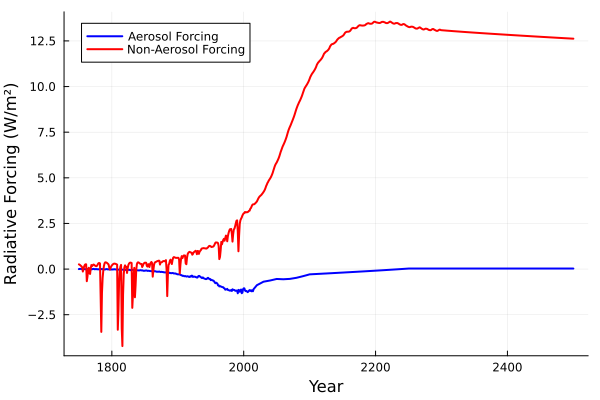

attempt to save state beyond implementation limit


In [53]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

In [112]:
# # TOTAL RADIATIVE F
F_total = forcing_non_aerosol + 0.8 * forcing_aerosol

# con 
c = 4.184
d = 86       
C = c * d    
λ = 2.1      
Δt = 1   

# EBM
function simulate_temperature(F_total, T0, t_start, t_end)
    N_steps = length(F_total)  
    T = zeros(N_steps) 
    T[1] = T0          
    
    for n in 1:(N_steps - 1)
        T[n+1] = T[n] + (Δt / C) * (F_total[n] - λ * T[n])
    end
    
    return T
end

simulate_temperature (generic function with 2 methods)

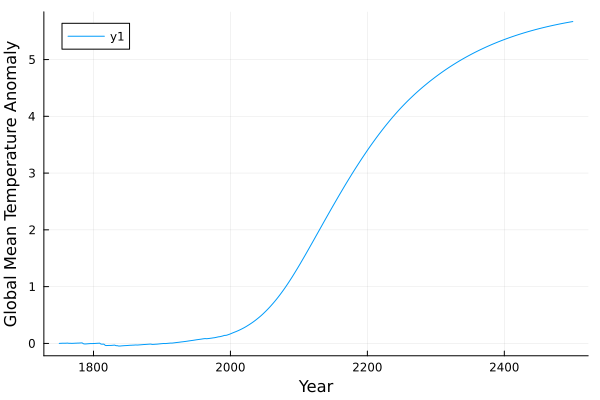

In [113]:
# Initial conditions/setting
T0 = 0.0  
temperatures = simulate_temperature(F_total, T0, 1750, 2500)


years = forcings_all[!,"year"]  
plot(years, temperatures, xlabel="Year", ylabel="Global Mean Temperature Anomaly")

In [116]:
# monte_carlo_simulation
function monte_carlo_simulation(F_total, T0, num_simulations)
    lambda_dist = LogNormal(log(2.1), log(2)/4)
    temperatures = zeros(num_simulations)
    
    for i in 1:num_simulations
        λ_sample = rand(lambda_dist)
        T = simulate_temperature(F_total, T0, λ_sample, t_end)
        temperatures[i] = T[end] 
    end
    
    return temperatures
end

num_simulations = 5000 
temperatures_mc = monte_carlo_simulation(F_total, T0, num_simulations)
mean_temp = mean(temperatures_mc) # mean_temp
ci_95 = quantile(temperatures_mc, [0.025, 0.975]) #confience interbals

println("mean temperatures: $mean_temp °C")
println("95% confience interbals: [$(ci_95[1]), $(ci_95[2])] °C")

# make comparision
T_fixed_lambda = simulate_temperature(F_total, T0, 2.1, t_end)
println("λ = 2.1: $(T_fixed_lambda[end]) °C")

mean temperatures: 5.669215762074454 °C
95% confience interbals: [5.6692157620744466, 5.6692157620744466] °C
λ = 2.1: 5.6692157620744466 °C


It seems that the these two results are very close. 
For the sample set, I can decide whether my sample set in a Monte Carlo simulation is sufficient by looking at the model's stability. In a well-constructed Monte Carlo simulation, if the increase of simulations does not significantly change the mean or confidence intervals, it's an indication that the sample set is sufficient. So, I increase this from 1,000 to 10,000 and didn't show significantly change.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

In [111]:
B_02_t = 45*0.85
N_02_t = 35*0.85

function calculate_DO_third(B_01, N_01, B_02, N_02, B_03, N_03, DO_waste3, distance_third)
    C_values_1 = Float64[]
    C_values_2 = Float64[]
    C_values_3 = Float64[]

    # Waste Stream 1
    DO_0_mixed = mixed_concentration(Q_river, Q_waste1, DO_river, DO_waste1)
    B_0_mixed = mixed_concentration(Q_river, Q_waste1, 5, B_01)
    N_0_mixed = mixed_concentration(Q_river, Q_waste1, 5, N_01)

    # 0-15
    for x in distances_1
        C_x = C_waste(x, DO_0_mixed, C_s, B_0_mixed, N_0_mixed, k_a, k_c, k_n, U)
        push!(C_values_1, C_x)
    end

    # Waste Stream 2
    DO_15 = C_values_1[end]
    B_15 = B_0_mixed * exp(-k_c * 15 / U)  
    N_15 = N_0_mixed * exp(-k_n * 15 / U)

    DO_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, DO_15, DO_waste2)
    B_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, B_15, B_02)
    N_15_mixed = mixed_concentration(Q_river + Q_waste1, Q_waste2, N_15, N_02)

    DO_3_mixed = DO_15_mixed
    B_3_mixed = B_15_mixed
    N_3_mixed = N_15_mixed
    # 15----
    for x in distances_2
        if x <= distance_third
            C_x = C_waste(x - 15, DO_15_mixed, C_s, B_15_mixed, N_15_mixed, k_a, k_c, k_n, U)
            push!(C_values_2, C_x)
       
            # do bo no in river
            DO_3r = C_values_2[end]
            B_3r = B_0_mixed * exp(-k_c * (distance_third - 15) / U)  
            N_3r = N_0_mixed * exp(-k_n * (distance_third - 15) / U)

            # 3 in
            DO_3_mixed = mixed_concentration(Q_river + Q_waste1 + Q_waste2, Q_waste3, DO_15_mixed, DO_waste3)
            B_3_mixed = mixed_concentration(Q_river + Q_waste1 + Q_waste2, Q_waste3, B_15_mixed, B_03)
            N_3_mixed = mixed_concentration(Q_river + Q_waste1 + Q_waste2, Q_waste3, N_15_mixed, N_03)
         
            C_x = C_waste(x - 15, DO_3_mixed, C_s, B_3_mixed, N_3_mixed, k_a, k_c, k_n, U)
            push!(C_values_3, C_x)
        else
            # after 3
            C_x = C_waste(x - 15, DO_3_mixed, C_s, B_3_mixed, N_3_mixed, k_a, k_c, k_n, U)
            push!(C_values_3, C_x)
        end
    end

    return vcat(C_values_1, C_values_2, C_values_3 )
end

function find_min_distance_3(B_01, N_01, B_02, N_02, B_03, N_03, DO_waste3)
    for dist_third in 15:0.1:50.0  # get min/step 0.1
        C_values = calculate_DO_third(B_01, N_01, B_02_t, N_02_t, B_03, N_03, DO_waste3, dist_third)

        if minimum(C_values) >= 4.0  
            return dist_third  
        end
    end  
end

B_03 = 50.0  # CBOD
N_03 = 45.0  # NBOD
DO_waste3 = 4.5  # DO

min_distance_third_discharge = find_min_distance_3(B_01, N_01, B_02, N_02, B_03, N_03, DO_waste3)

println("The third wastewater discharge should be placed at least $min_distance_third_discharge km")

The third wastewater discharge should be placed at least 15.0 km


## References

List any external references consulted, including classmates.